In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
import string
import re
import sklearn.metrics as sm
import imblearn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/website-classification/website_classification.csv


In [2]:
!pip install imbalanced-learn

#### Common Domain Suffixes in the United States
.com - Commercial

A company owns the site.  A .com can be the company's actual Web site or it can be a Web space that a company sells to people.  Commercial sites are often difficult to evaluate because companies may include educational information on portions of their sites.  For example, the Duracell site information about sustainability and disposal.  You must decided on a case-by-case basis whether a particular site's information outweighs its commercial / advertising agenda.

.org - Non-Profit Organization

If you use a non-profit organization's site, think about the organization's agenda and how it's likely to influence the way they present information.

.edu - Educational

A .edu site is from a college or university, such as the University of Washington's http://www.washington.edu.  Usually, this means that the site has good information, but sometimes colleges and universities give Web space to students.  Remember that the students may or may not check their facts when they put information up on the Web.  

.gov - U.S. Government

These sites are produced by some part of the United States government (federal, state, county, or city government).

.mil - U.S. Military

These sites are produced by branches of the United States military (Army, Navy, Marines, Coast Guard, etc.)

.net Internet-Related Service

This means that the site has something to do with providing internet-related service.  Local internet service providers will have .net as part of their addresses, although they might also be .com.

.k12 - K-12 School

These sites come from K-12 Schools (kindergarten through 12th grade) and can include pages created by teachers and students.

~ - Individual 

If you see a tilde (~) in the Web address, you'll know that an individual created the page.  Make sure that the individual cites their sources if you're considering to use the information in your research.  Note:  Universities offer Web space to their faculty, staff, and students.  If you're studying a subject in which the individual whose page you're looking at is a prominent researcher, it's probably all right if she doesn't cite outside sources when she discusses the topic of her own expertise.  

In [3]:
##### read the dataset
website_df= pd.read_csv('../input/website-classification/website_classification.csv')
website_df

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel
...,...,...,...,...
1403,1403,http://www.oldwomen.org/,old nude women porn mature granny sex horny ol...,Adult
1404,1404,http://www.webcamslave.com,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult
1405,1405,http://www.buyeuroporn.com/,porno dvd online european porn dvd cheap adult...,Adult
1406,1406,http://www.analdreamhouse.com/30/03/agecheck/i...,anal dream house anal dream house anal dream h...,Adult


In [4]:
website_url_df= website_df[['website_url','Category']]

In [5]:
#### temporary purposes (deleting the unnamed: 0 & website_url)

website_df.drop(['Unnamed: 0','website_url'],axis=1,inplace=True)

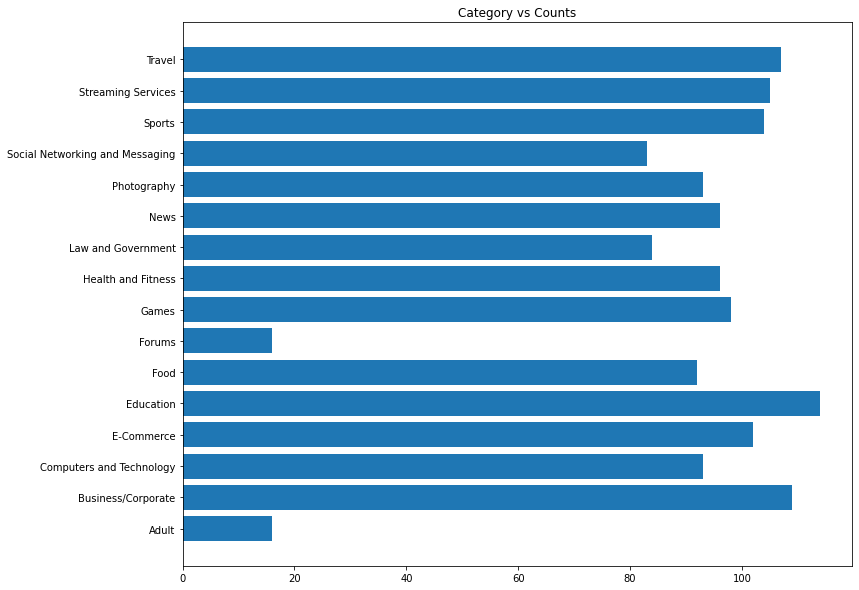

In [6]:
#### let's study the count of each category

plt.figure(figsize=(12,10))
plt.title('Category vs Counts')
website_category_df= pd.DataFrame(website_df.groupby('Category').size(),columns=['Count'])
plt.barh(width=website_category_df['Count'],y=website_category_df.index)
plt.show()

##### Almost all category are in same count except for forums and adults

##                                                      Data Cleaning & Engineering

#### converts the letters of word to lower case

In [7]:


website_df['cleaned_website_text']= website_df['cleaned_website_text'].apply(lambda x:x.lower())


##### splits the sentence to the list of words

In [8]:

from nltk.tokenize import word_tokenize
website_df['tokenized_words'] = website_df['cleaned_website_text'].apply(lambda x:word_tokenize(x))
website_df

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


#### removing special characters (if anything is there still)

In [9]:

website_df['tokenized_words'] = website_df['tokenized_words'].apply(lambda x:[re.sub(f'[{string.punctuation}]+','',i) for i in x if i not in list(string.punctuation)])
website_df
                                                                    

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


#### Removing stopwords

In [10]:
from nltk.corpus import stopwords
website_df['tokenized_words'] = website_df['tokenized_words'].apply(lambda x:[i for i in x if i not in stopwords.words('english')])
website_df

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, sites, like, use, vacat..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, sites, like, previo..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flights, search, compare, flights, mom..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, women, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cams, bdsm, chat, bondage, cams, free, ..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


#### Lemmatizing the words

In [11]:
from nltk.stem.wordnet import WordNetLemmatizer
wordnetlemmatizer= WordNetLemmatizer()
website_df['tokenized_words']=website_df['tokenized_words'].apply(lambda x:[wordnetlemmatizer.lemmatize(i) for i in x])
website_df

,cleaned_website_text,Category,tokenized_words
0,official site good hotel accommodation big sav...,Travel,"[official, site, good, hotel, accommodation, b..."
1,expedia hotel book sites like use vacation wor...,Travel,"[expedia, hotel, book, site, like, use, vacati..."
2,tripadvisor hotel book sites like previously d...,Travel,"[tripadvisor, hotel, book, site, like, previou..."
3,cheap flights search compare flights momondo f...,Travel,"[cheap, flight, search, compare, flight, momon..."
4,bot create free account create free account si...,Travel,"[bot, create, free, account, create, free, acc..."
...,...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult,"[old, nude, woman, porn, mature, granny, sex, ..."
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult,"[bdsm, cam, bdsm, chat, bondage, cam, free, bd..."
1405,porno dvd online european porn dvd cheap adult...,Adult,"[porno, dvd, online, european, porn, dvd, chea..."
1406,anal dream house anal dream house anal dream h...,Adult,"[anal, dream, house, anal, dream, house, anal,..."


In [12]:
#### join the tokenized words
website_df['tokenized_words']= website_df['tokenized_words'].apply(lambda x:' '.join(x))


In [13]:
#dropping the unnecessary columns
website_df.drop(['cleaned_website_text'],axis=1,inplace=True)


In [14]:
### changing the order of columns and renaming them

website_df=website_df[['tokenized_words','Category']]
website_df.columns=['Website Cleaned Text','Category']

website_df

,Website Cleaned Text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book site like use vacation work...,Travel
2,tripadvisor hotel book site like previously de...,Travel
3,cheap flight search compare flight momondo fin...,Travel
4,bot create free account create free account si...,Travel
...,...,...
1403,old nude woman porn mature granny sex horny ol...,Adult
1404,bdsm cam bdsm chat bondage cam free bdsm video...,Adult
1405,porno dvd online european porn dvd cheap adult...,Adult
1406,anal dream house anal dream house anal dream h...,Adult


In [15]:
#### converts the category to labels using label encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
website_df['Category']= le.fit_transform(website_df['Category'])

In [16]:
website_df

,Website Cleaned Text,Category
0,official site good hotel accommodation big sav...,15
1,expedia hotel book site like use vacation work...,15
2,tripadvisor hotel book site like previously de...,15
3,cheap flight search compare flight momondo fin...,15
4,bot create free account create free account si...,15
...,...,...
1403,old nude woman porn mature granny sex horny ol...,0
1404,bdsm cam bdsm chat bondage cam free bdsm video...,0
1405,porno dvd online european porn dvd cheap adult...,0
1406,anal dream house anal dream house anal dream h...,0


In [17]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(website_df['Website Cleaned Text'],website_df['Category'],test_size=0.3,random_state=0)


In [18]:
#### converting the text to frequency (using TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizer= TfidfVectorizer()
X_train= tf_idf_vectorizer.fit_transform(X_train)
X_train= pd.DataFrame(X_train.toarray(),columns=tf_idf_vectorizer.get_feature_names())



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
y_train.value_counts()

14    81
4     77
3     76
13    75
8     75
7     72
15    70
1     69
2     69
12    65
9     62
10    59
5     58
11    54
0     12
6     11
Name: Category, dtype: int64

In [20]:
#### using the SMOTE/oversampler
from imblearn.over_sampling import SMOTE,RandomOverSampler
sampling_strategy={14:81,4:77,3:76,13:75,8:75,7:72,15:70,1:69,2:69,12:65,9:62,10:59,5:58,11:54,0:60,6:60}
oversample = RandomOverSampler(sampling_strategy=sampling_strategy)
X_train,y_train= oversample.fit_resample(X_train,y_train)


In [21]:
y_train.value_counts()

14    81
4     77
3     76
13    75
8     75
7     72
15    70
1     69
2     69
12    65
9     62
6     60
0     60
10    59
5     58
11    54
Name: Category, dtype: int64

In [22]:
#### applying the algorithm
from sklearn.naive_bayes import MultinomialNB
model_clf= MultinomialNB()
model_clf.fit(X_train,y_train)

MultinomialNB()

In [23]:

X_test= tf_idf_vectorizer.transform(X_test)
X_test= pd.DataFrame(X_test.toarray(),columns=tf_idf_vectorizer.get_feature_names())
y_pred= model_clf.predict(X_test)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,model_clf.predict(X_train))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The accuracy of train model is 0.9953789279112755
The accuracy of test model is 0.8912529550827423


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


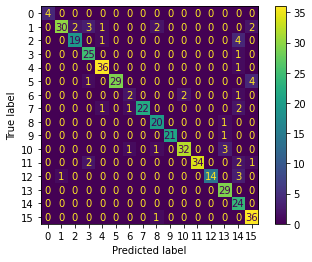

In [24]:
sm.plot_confusion_matrix(model_clf,X_test,y_test)

#### Initial Results seems to be good , But there is a small kind of overfitting

In [25]:
### tuning the hyperparameters of multinomialnb via gridsearchcv
from sklearn.model_selection import GridSearchCV
model_clf= MultinomialNB()
param_grid= {'alpha':np.linspace(0.5, 1.5, 6),'fit_prior':[True,False]}
grid_model= GridSearchCV(model_clf,param_grid=param_grid,cv=5,return_train_score=True,scoring='accuracy',verbose=10,error_score=0)
grid_model.fit(X_train,y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START alpha=0.5, fit_prior=True..................................
[CV 1/5; 1/12] END alpha=0.5, fit_prior=True;, score=(train=0.994, test=0.912) total time=   1.1s
[CV 2/5; 1/12] START alpha=0.5, fit_prior=True..................................
[CV 2/5; 1/12] END alpha=0.5, fit_prior=True;, score=(train=0.997, test=0.931) total time=   1.2s
[CV 3/5; 1/12] START alpha=0.5, fit_prior=True..................................
[CV 3/5; 1/12] END alpha=0.5, fit_prior=True;, score=(train=0.995, test=0.907) total time=   1.1s
[CV 4/5; 1/12] START alpha=0.5, fit_prior=True..................................
[CV 4/5; 1/12] END alpha=0.5, fit_prior=True;, score=(train=0.997, test=0.866) total time=   1.1s
[CV 5/5; 1/12] START alpha=0.5, fit_prior=True..................................
[CV 5/5; 1/12] END alpha=0.5, fit_prior=True;, score=(train=0.993, test=0.917) total time=   1.1s
[CV 1/5; 2/12] START alpha=0.5, fit_prior=Fa

GridSearchCV(cv=5, error_score=0, estimator=MultinomialNB(),
             param_grid={'alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'fit_prior': [True, False]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [26]:
print(f'The best params are: {grid_model.best_params_} ')
print(f'The best score are: {grid_model.best_score_} ')

The best params are: {'alpha': 0.5, 'fit_prior': False} 
The best score are: 0.920489844683393 


In [27]:
model_clf= MultinomialNB(**grid_model.best_params_)
model_clf.fit(X_train,y_train)
y_pred= model_clf.predict(X_test)
print(f'The accuracy of train model after tuning is {sm.accuracy_score(y_train,model_clf.predict(X_train))}')
print(f'The accuracy of test model after tuning is {sm.accuracy_score(y_test,y_pred)}')


The accuracy of train model after tuning is 0.9935304990757856
The accuracy of test model after tuning is 0.9125295508274232


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3600x1728 with 0 Axes>

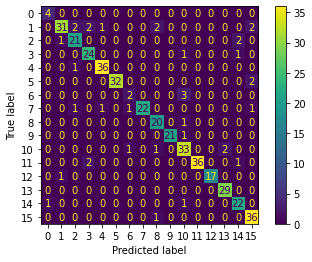

In [28]:
plt.figure(figsize=(50,24))
sm.plot_confusion_matrix(model_clf,X_test,y_test)
plt.show()

In [29]:
print(sm.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.94      0.78      0.85        40
           2       0.84      0.88      0.86        24
           3       0.86      0.92      0.89        26
           4       0.95      0.97      0.96        37
           5       1.00      0.94      0.97        34
           6       0.50      0.40      0.44         5
           7       1.00      0.85      0.92        26
           8       0.83      0.95      0.89        21
           9       1.00      0.95      0.98        22
          10       0.82      0.89      0.86        37
          11       1.00      0.92      0.96        39
          12       1.00      0.94      0.97        18
          13       0.94      1.00      0.97        29
          14       0.85      0.92      0.88        24
          15       0.88      0.97      0.92        37

    accuracy                           0.91       423
   macro avg       0.89   

#### Model (Multinomial NB) is good after hyperparameter tuning in- terms of accuracy, percision and recall. 

#### But for class(label) 0 & 6, recall & precision seems to be showing good value after proper oversampling........... 

In [30]:
from sklearn.svm import SVC
svc_clf= SVC()
svc_clf.fit(X_train,y_train)

SVC()

In [31]:
y_pred= svc_clf.predict(X_test)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,svc_clf.predict(X_train))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 1.0
The accuracy of test model is 0.8770685579196218


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


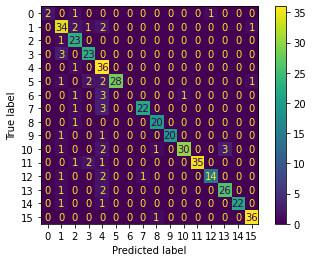

In [32]:
sm.plot_confusion_matrix(svc_clf,X_test,y_test)

In [33]:
### studying with respect to Regularization parameter:

estimator= SVC()
#parameters= {'C':[0.1,1,10,100,1000],'kernel':['polynomial', 'rbf', 'sigmoid','linear'],'gamma':[1,0.1,0.01,0.001]}
parameters= {'C':[0.1,1,10,100,1000]}
svc_clf= GridSearchCV(estimator=estimator,param_grid=parameters,cv=5,return_train_score=True,scoring='accuracy',verbose=10,error_score=0)
svc_clf.fit(X_train,y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
[CV 1/5; 1/5] END ....C=0.1;, score=(train=0.106, test=0.088) total time=  49.0s
[CV 2/5; 1/5] START C=0.1.......................................................
[CV 2/5; 1/5] END ....C=0.1;, score=(train=0.109, test=0.097) total time=  48.2s
[CV 3/5; 1/5] START C=0.1.......................................................
[CV 3/5; 1/5] END ....C=0.1;, score=(train=0.090, test=0.102) total time=  49.1s
[CV 4/5; 1/5] START C=0.1.......................................................
[CV 4/5; 1/5] END ....C=0.1;, score=(train=0.097, test=0.097) total time=  48.6s
[CV 5/5; 1/5] START C=0.1.......................................................
[CV 5/5; 1/5] END ....C=0.1;, score=(train=0.103, test=0.097) total time=  48.9s
[CV 1/5; 2/5] START C=1.........................................................
[CV 1/5; 2/5] END ......C=1;, score=(train=1.000,

GridSearchCV(cv=5, error_score=0, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, return_train_score=True,
             scoring='accuracy', verbose=10)

In [34]:
print(f'The best params are: {svc_clf.best_params_} ')
print(f'The best score are: {svc_clf.best_score_} ')

The best params are: {'C': 10} 
The best score are: 0.8900110940433521 


In [35]:
df_results_C= pd.DataFrame(svc_clf.cv_results_)
df_results_C

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,33.523956,0.365305,15.230978,0.277906,0.1,{'C': 0.1},0.087558,0.096774,0.101852,0.097222,...,0.096126,0.004670,5,0.106358,0.108671,0.090069,0.096998,0.102771,0.100973,0.006726
1,31.969918,0.642155,13.506857,0.270773,1,{'C': 1},0.912442,0.824885,0.851852,0.837963,...,0.864132,0.033387,4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,31.324762,0.332624,13.485719,0.227307,10,{'C': 10},0.921659,0.866359,0.879630,0.865741,...,0.890011,0.024365,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,31.794690,0.346689,13.270658,0.198464,100,{'C': 100},0.921659,0.866359,0.879630,0.865741,...,0.890011,0.024365,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,31.487071,0.279213,13.189745,0.077461,1000,{'C': 1000},0.921659,0.866359,0.879630,0.865741,...,0.890011,0.024365,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


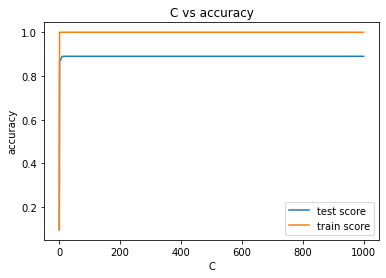

In [36]:
#plotting C with accuracy 
plt.plot(df_results_C['param_C'],df_results_C['mean_test_score'], label='test score')
plt.plot(df_results_C['param_C'],df_results_C['mean_train_score'], label='train score')
plt.title('C vs accuracy')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [37]:
svc_clf_C= SVC(C=10)
svc_clf_C.fit(X_train,y_train)
y_pred= svc_clf_C.predict(X_test)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,svc_clf_C.predict(X_train))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 1.0
The accuracy of test model is 0.8841607565011821


In [38]:
### studying with respect to kernel parameter:

estimator= SVC()
#parameters= {'C':[0.1,1,10,100,1000],'kernel':['polynomial', 'rbf', 'sigmoid','linear'],'gamma':[1,0.1,0.01,0.001]}
parameters= {'kernel':['polynomial', 'rbf', 'sigmoid','linear']}
svc_clf= GridSearchCV(estimator=estimator,param_grid=parameters,cv=5,return_train_score=True,scoring='accuracy',verbose=10,error_score=0)
svc_clf.fit(X_train,y_train)
print(f'The best params are: {svc_clf.best_params_} ')
print(f'The best score are: {svc_clf.best_score_} ')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START kernel=polynomial...........................................
[CV 1/5; 1/4] END kernel=polynomial;, score=(train=0.000, test=0.000) total time=   0.9s
[CV 2/5; 1/4] START kernel=polynomial...........................................
[CV 2/5; 1/4] END kernel=polynomial;, score=(train=0.000, test=0.000) total time=   0.9s
[CV 3/5; 1/4] START kernel=polynomial...........................................
[CV 3/5; 1/4] END kernel=polynomial;, score=(train=0.000, test=0.000) total time=   1.0s
[CV 4/5; 1/4] START kernel=polynomial...........................................
[CV 4/5; 1/4] END kernel=polynomial;, score=(train=0.000, test=0.000) total time=   1.2s
[CV 5/5; 1/4] START kernel=polynomial...........................................
[CV 5/5; 1/4] END kernel=polynomial;, score=(train=0.000, test=0.000) total time=   0.9s
[CV 1/5; 2/4] START kernel=rbf..................................................
[CV 1/5; 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 333, in _dense_fit
    random_seed=random_seed,
  File "sklearn/svm/_libsvm.pyx", line 176, 

The best params are: {'kernel': 'sigmoid'} 
The best score are: 0.9168074756784433 


In [39]:
svc_clf_kernel= SVC(kernel='sigmoid')
svc_clf_kernel.fit(X_train,y_train)
y_pred= svc_clf_kernel.predict(X_test)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,svc_clf_kernel.predict(X_train))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 0.9981515711645101
The accuracy of test model is 0.9101654846335697


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


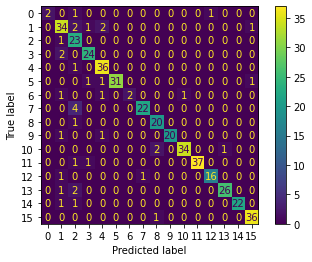

In [40]:
sm.plot_confusion_matrix(svc_clf_kernel,X_test,y_test)

In [41]:
### studying with respect to gamma parameter:

estimator= SVC()
#parameters= {'C':[0.1,1,10,100,1000],'kernel':['polynomial', 'rbf', 'sigmoid','linear'],'gamma':[1,0.1,0.01,0.001]}
parameters= {'gamma':[1,0.1,0.01,0.001]}
svc_clf= GridSearchCV(estimator=estimator,param_grid=parameters,cv=5,return_train_score=True,scoring='accuracy',verbose=10,error_score=0)
svc_clf.fit(X_train,y_train)
print(f'The best params are: {svc_clf.best_params_} ')
print(f'The best score are: {svc_clf.best_score_} ')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START gamma=1.....................................................
[CV 1/5; 1/4] END ..gamma=1;, score=(train=1.000, test=0.912) total time=  45.9s
[CV 2/5; 1/4] START gamma=1.....................................................
[CV 2/5; 1/4] END ..gamma=1;, score=(train=1.000, test=0.825) total time=  44.8s
[CV 3/5; 1/4] START gamma=1.....................................................
[CV 3/5; 1/4] END ..gamma=1;, score=(train=1.000, test=0.852) total time=  46.9s
[CV 4/5; 1/4] START gamma=1.....................................................
[CV 4/5; 1/4] END ..gamma=1;, score=(train=1.000, test=0.838) total time=  46.9s
[CV 5/5; 1/4] START gamma=1.....................................................
[CV 5/5; 1/4] END ..gamma=1;, score=(train=1.000, test=0.894) total time=  45.8s
[CV 1/5; 2/4] START gamma=0.1...................................................
[CV 1/5; 2/4] END gamma=0.1;, score=(train=0.664,

In [42]:
svc_clf_gamma= SVC(gamma=1)
svc_clf_gamma.fit(X_train,y_train)
y_pred= svc_clf_gamma.predict(X_test)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,svc_clf_gamma.predict(X_train))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 1.0
The accuracy of test model is 0.8770685579196218


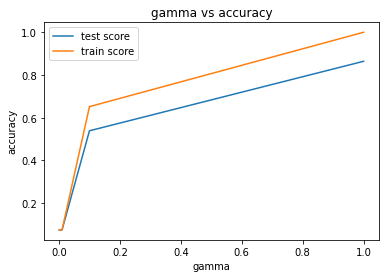

In [43]:
#plotting gamma with accuracy 
df_results_gamma= pd.DataFrame(svc_clf.cv_results_)
plt.plot(df_results_gamma['param_gamma'],df_results_gamma['mean_test_score'], label='test score')
plt.plot(df_results_gamma['param_gamma'],df_results_gamma['mean_train_score'], label='train score')
plt.title('gamma vs accuracy')
plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [44]:
#### studying with respect to all parameters
from sklearn.model_selection import RandomizedSearchCV
estimator= SVC()
parameters= {'C':[0.1,1,10,100,1000],'kernel':['polynomial', 'rbf', 'sigmoid','linear'],'gamma':[1,0.1,0.01,0.001]}
svc_clf= RandomizedSearchCV(estimator=estimator,param_distributions=parameters,cv=5,n_iter=5,return_train_score=True,scoring='accuracy',verbose=10,error_score=0)
svc_clf.fit(X_train,y_train)
print(f'The best params are: {svc_clf.best_params_} ')
print(f'The best score are: {svc_clf.best_score_} ')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1, gamma=0.1, kernel=sigmoid............................
[CV 1/5; 1/5] END C=0.1, gamma=0.1, kernel=sigmoid;, score=(train=0.075, test=0.074) total time=  39.5s
[CV 2/5; 1/5] START C=0.1, gamma=0.1, kernel=sigmoid............................
[CV 2/5; 1/5] END C=0.1, gamma=0.1, kernel=sigmoid;, score=(train=0.074, test=0.078) total time=  39.9s
[CV 3/5; 1/5] START C=0.1, gamma=0.1, kernel=sigmoid............................
[CV 3/5; 1/5] END C=0.1, gamma=0.1, kernel=sigmoid;, score=(train=0.075, test=0.074) total time=  39.0s
[CV 4/5; 1/5] START C=0.1, gamma=0.1, kernel=sigmoid............................
[CV 4/5; 1/5] END C=0.1, gamma=0.1, kernel=sigmoid;, score=(train=0.075, test=0.074) total time=  39.0s
[CV 5/5; 1/5] START C=0.1, gamma=0.1, kernel=sigmoid............................
[CV 5/5; 1/5] END C=0.1, gamma=0.1, kernel=sigmoid;, score=(train=0.075, test=0.074) total time=  41.8s
[CV 1/5; 2/5] S

In [45]:
svc_clf= SVC(**svc_clf.best_params_)
svc_clf.fit(X_train,y_train)
y_pred= svc_clf.predict(X_test)
print(f'The accuracy of train model is {sm.accuracy_score(y_train,svc_clf.predict(X_train))}')
print(f'The accuracy of test model is {sm.accuracy_score(y_test,y_pred)}')

The accuracy of train model is 1.0
The accuracy of test model is 0.9125295508274232


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


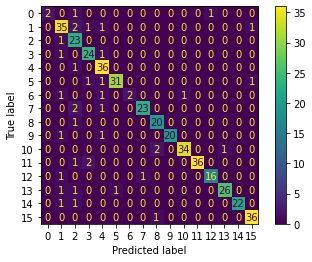

In [46]:
sm.plot_confusion_matrix(svc_clf,X_test,y_test)

In [47]:
print(sm.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.83      0.88      0.85        40
           2       0.70      0.96      0.81        24
           3       0.86      0.92      0.89        26
           4       0.86      0.97      0.91        37
           5       0.97      0.91      0.94        34
           6       1.00      0.40      0.57         5
           7       0.96      0.88      0.92        26
           8       0.87      0.95      0.91        21
           9       1.00      0.91      0.95        22
          10       0.97      0.92      0.94        37
          11       1.00      0.92      0.96        39
          12       0.94      0.89      0.91        18
          13       0.96      0.90      0.93        29
          14       1.00      0.92      0.96        24
          15       0.95      0.97      0.96        37

    accuracy                           0.91       423
   macro avg       0.93   

##### from this , it gives me a idea that SVC is also performing better when looking at accuracy and classification report 